# Analysis on Los Angeles, California Data.
PM 2.5 Sample Measurements. Scatter Plot displaying annual results. IQR Results. Box plot with outliers.

In [162]:
%matplotlib inline

In [163]:
# Dependencies and Setup
import matplotlib.cbook as cbook
import matplotlib.dates as dates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np

import json
import copy
from typing import List

import csv
import os

Import saved csv. CSV includes data generated from 'StateCountySampleDataDF()' function.

In [164]:
# Import from .CSV
california_df = pd.read_csv("./csv_data/california_losangeles.csv") 

In [165]:
# Verify california is in dataframe
assert california_df['state'][0] == 'California'

In [166]:
# Make copy before filtering
california_filtered_df = california_df.copy()

## **Clean Data before processing**

Search for outliers in sample data.

In [167]:
# Find max value in sample data
california_filtered_df['sample_measurement'].max()

995.6

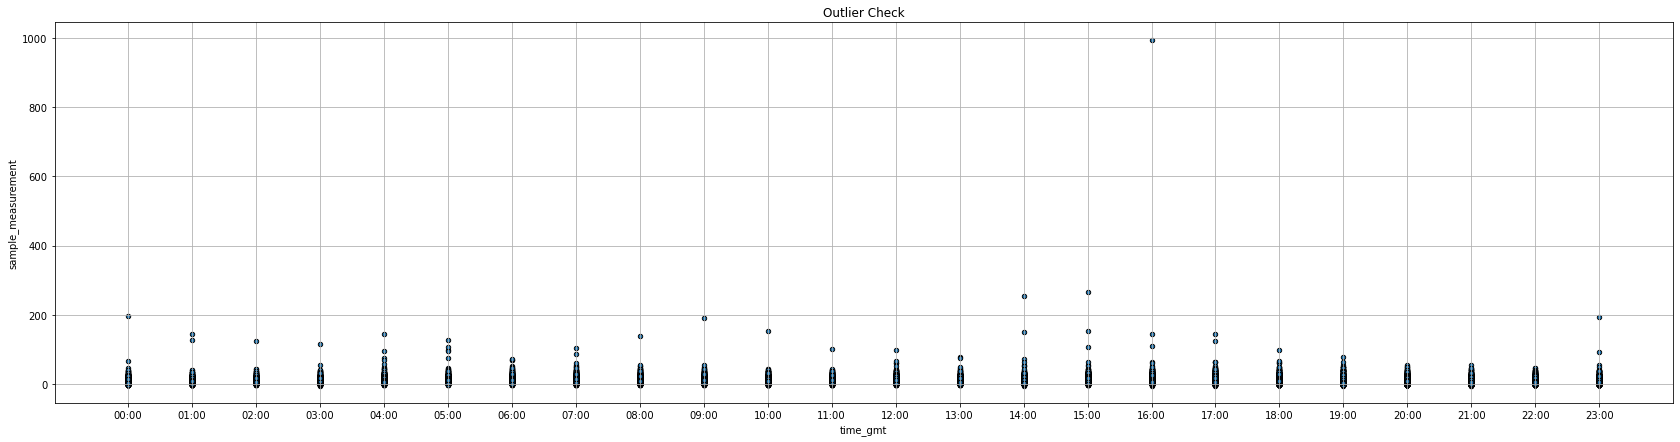

In [168]:
#Use Scatter Plot to visualize outliers.
california_filtered_df.sort_values(by='time_gmt', axis=0).plot('time_gmt', 
                    'sample_measurement', 
                    kind='scatter', 
                    grid=True, 
                    title=f'Outlier Check', 
                    edgecolors='black',
                    linewidths=.9,
                    figsize=(29, 7))

plt.show()

In [169]:
# Based off the scatter plot, outliers can be found with a sample data over 400. Show all outliers over 400 sample measurement.
outlier = california_filtered_df[(california_filtered_df[['sample_measurement']] > 400).all(axis=1)]
outlier

,state_code,state,county_code,county,site_number,parameter,sample_measurement,units_of_measure,latitude,longitude,date_local,time_local,date_gmt,time_gmt,method_type,method_code,method,date_of_last_change,cbsa_code
15560,6,California,37,Los Angeles,1201,Acceptable PM2.5 AQI & Speciation Mass,995.6,Micrograms/cubic meter (LC),34.19925,-118.53276,2019-10-11,08:00,2019-10-11,16:00,Non-FRM,731,Met-One BAM-1020 W/PM2.5 SCC - Beta Attenuation,2020-03-25,31080


#### **Continue: Cleaned dataframe being used for analysis**

In [170]:
# Select certain columns to use for mapping, 
california_filtered_df=california_filtered_df[['county','site_number','sample_measurement','latitude','longitude','time_local','date_gmt','time_gmt','date_of_last_change']]
# Drop nan values and empty values
california_filtered_df=california_filtered_df.dropna()
# Remove all numbers below 0 and above 400
california_filtered_df=california_filtered_df[(california_filtered_df[['sample_measurement']] > 0).all(axis=1) & (california_filtered_df[['sample_measurement']] < 400).all(axis=1)]

ca_filtered_noIndexChange = california_filtered_df

In [171]:
# Assign date_gmt DateTimeIndex. Allows for date searching throug index.
california_filtered_df['date_gmt']=pd.DatetimeIndex(california_filtered_df['date_gmt'])
#Set index to date_gmt
california_filtered_df = california_filtered_df.set_index('date_gmt')

In [172]:
# Copy of clean data
california_clean_data = california_filtered_df.copy()

**Tool**: Search index by date range

In [173]:
# Search index by date range
california_clean_data['2019-01-01':'2019-02-02']

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change
date_gmt,,,,,,,,
2019-01-01,Los Angeles,16,6.2,34.14435,-117.85036,00:00,08:00,2019-06-24
2019-01-01,Los Angeles,16,6.4,34.14435,-117.85036,01:00,09:00,2019-06-24
2019-01-01,Los Angeles,16,7.7,34.14435,-117.85036,02:00,10:00,2019-06-24
2019-01-01,Los Angeles,16,7.2,34.14435,-117.85036,03:00,11:00,2019-06-24
2019-01-01,Los Angeles,16,5.2,34.14435,-117.85036,04:00,12:00,2019-06-24
...,...,...,...,...,...,...,...,...
2019-02-02,Los Angeles,4004,5.3,33.79236,-118.17533,11:00,19:00,2019-06-24
2019-02-02,Los Angeles,4004,5.1,33.79236,-118.17533,12:00,20:00,2019-06-24
2019-02-02,Los Angeles,4004,3.9,33.79236,-118.17533,13:00,21:00,2019-06-24


In [174]:
# Color thresholds
colors_list = []
for row in california_clean_data['sample_measurement']:
    # if more than a value,
    if row > 55.5:
        # Append color value
        colors_list.append('#e80c0c')
    # else, if more than a value,
    elif row > 35.5:
        # Append color value
        colors_list.append('#e8970c')
    elif row > 12.1:
        # Append color value
        colors_list.append('#dbe36b')
    elif row > 0:
        # Append color value
        colors_list.append('#5cb85c')
    else:
        # Append a failing grade
        colors_list.append('Failed')
        #print(f'failed to apply color on row {row}')
        
# Create a column from the list
california_clean_data['color'] = colors_list

california_clean_data['color'].value_counts()

#5cb85c    26890
#dbe36b    14575
#e8970c      300
#e80c0c       59
Name: color, dtype: int64

------

### **Difference in colors warning & how much time we spend in different air qualities**

#### **Objective**
Use full Sample Dataset. Get percentage of dataset that is in Good, Moderate, Unhealthy and Very Unhealthy for the year.

In [175]:
living_in_air_pollution_percentage = []

In [176]:
living_in_air_pollution_percentage.append(california_clean_data['color'].value_counts()[0]/california_clean_data['color'].value_counts().sum())
living_in_air_pollution_percentage.append(california_clean_data['color'].value_counts()[1]/california_clean_data['color'].value_counts().sum())
living_in_air_pollution_percentage.append(california_clean_data['color'].value_counts()[2]/california_clean_data['color'].value_counts().sum())
living_in_air_pollution_percentage.append(california_clean_data['color'].value_counts()[3]/california_clean_data['color'].value_counts().sum())


In [177]:
# Round value.
round_value = [round(num, 2) for num in living_in_air_pollution_percentage]
key_list = ['Good (0 - 12.0):', 'Moderate (12.1 - 35.4):', 'Unhealthy (55.5 - 150.4):', 'Very Unhealthy (150.2+):']
#key_list = ['Green:','Yellow:','Orange:','Red:']

# Combine both for loop generated list into one.
percentage_rounded = [dict(zip(key_list, round_value))]
percentage_rounded

[{'Good (0 - 12.0):': 0.64,
  'Moderate (12.1 - 35.4):': 0.35,
  'Unhealthy (55.5 - 150.4):': 0.01,
  'Very Unhealthy (150.2+):': 0.0}]

In [178]:
# Display Percentage Rounded (above) in a DataFrame. Used to plot.
percentage_rounded_df = pd.DataFrame(percentage_rounded)
percentage_rounded_df

,Good (0 - 12.0):,Moderate (12.1 - 35.4):,Unhealthy (55.5 - 150.4):,Very Unhealthy (150.2+):
0,0.64,0.35,0.01,0.0


In [179]:
# Get column names
res_columns=percentage_rounded_df.columns

In [180]:
# Results for plot
results=percentage_rounded_df.iloc[0]

In [181]:
# Group means for plotting red line. Might use. 
group_means=results.mean()

In [182]:
# Function to convert x-label value into percentage. 
def currency(x, pos):
    """The two args are the value and tick position"""
    if x >= 1e6:
        s = '{:.0%}'.format(x)
    else:
        s = '{:.0%}'.format(x)
    return s
formatter = FuncFormatter(currency)

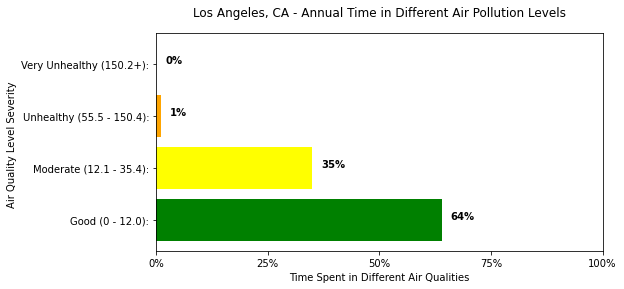

In [183]:
# Plot Percentage of time spent in different air quality.
fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(res_columns,results, color=('green','yellow','orange','red'))
labels = ax.get_xticklabels()

plt.setp(labels, 
         horizontalalignment='center')

# Add a vertical line, here we set the style in the function call
#ax.axvline(group_means,ls='--', color='r')

# Text values next to bars
for i, v in enumerate(results):
    ax.text(v + .02, i + .01, ('{:.0%}'.format(v)), color='black', fontweight='bold')

# Move title higher
ax.title.set(y=1.05)

ax.set(xlabel='Time Spent in Different Air Qualities', 
       ylabel='Air Quality Level Severity ',
       title='Los Angeles, CA - Annual Time in Different Air Pollution Levels')
ax.xaxis.set_major_formatter(formatter)

# Set xticks range
ax.set_xticks([0.0, .25, .5, .75, 1.0])
plt.savefig("./Images/LA_Annual_TimeInPollution_bar.png")
plt.show()

---------

## **Single date - California Air Pollution Data**
Date: 2019-01-01

In [184]:
# Single date - California Air Pollution Data
single_date_ca_air = california_clean_data.loc['2019-01-01']
#single_date_ca_air
#california_clean_data

In [185]:
range_time = single_date_ca_air['time_gmt'].sort_values().unique()

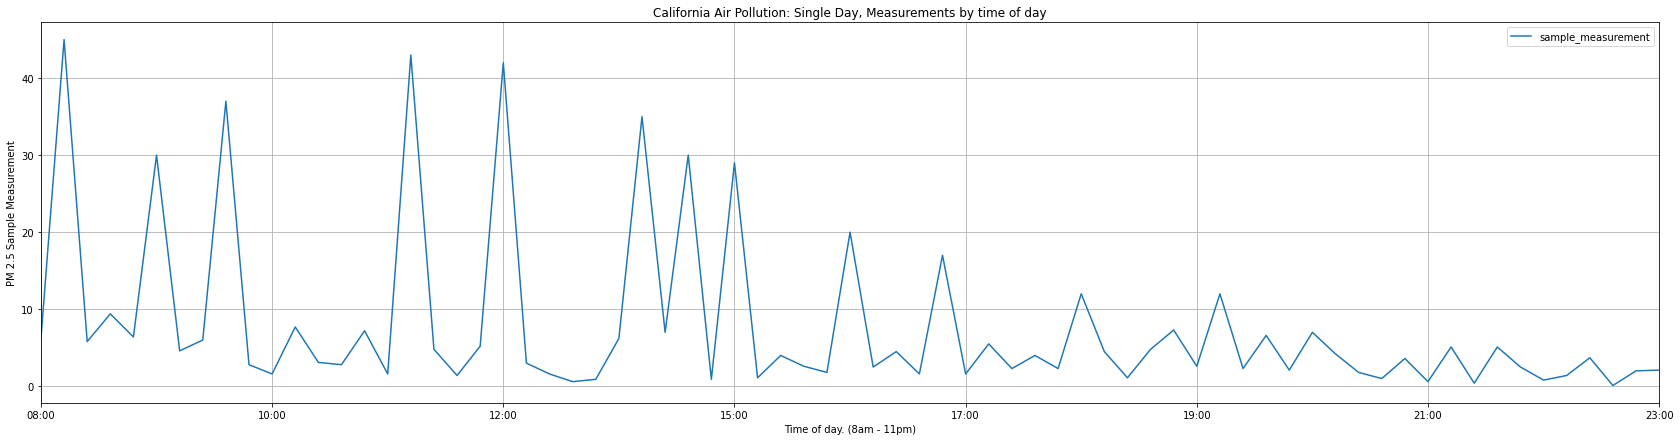

In [186]:
single_date_ca_air.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement', kind='line', figsize=(29, 7),grid=True, title="California Air Pollution: Single Day, Measurements by time of day")
#plt.xticks(np.arange(int(test),int(test2), 3.5))
plt.ylabel('PM 2.5 Sample Measurement')
plt.xlabel('Time of day. (8am - 11pm)')
plt.xlim([0,70])
plt.show()

## **Annual California Air Pollution. Measurement by Day of Year.**
Date Range: 2019-01-01 - 2019-12-02

In [187]:
california_clean_data.sort_values(by='time_gmt', axis=0)

,county,site_number,sample_measurement,latitude,longitude,time_local,time_gmt,date_of_last_change,color
date_gmt,,,,,,,,,
2019-10-14,Los Angeles,1201,17.8,34.19925,-118.53276,16:00,00:00,2020-03-25,#dbe36b
2019-05-31,Los Angeles,1103,13.0,34.06659,-118.22688,16:00,00:00,2019-10-07,#dbe36b
2019-07-11,Los Angeles,4004,11.1,33.79236,-118.17533,16:00,00:00,2020-02-10,#5cb85c
2019-11-25,Los Angeles,16,7.6,34.14435,-117.85036,16:00,00:00,2020-03-24,#5cb85c
2019-06-14,Los Angeles,6012,12.1,34.38344,-118.52840,16:00,00:00,2019-10-07,#5cb85c
...,...,...,...,...,...,...,...,...,...
2019-05-02,Los Angeles,6012,16.3,34.38344,-118.52840,15:00,23:00,2019-10-07,#dbe36b
2019-12-22,Los Angeles,16,7.8,34.14435,-117.85036,15:00,23:00,2020-03-24,#5cb85c
2019-04-11,Los Angeles,1103,6.0,34.06659,-118.22688,15:00,23:00,2019-10-07,#5cb85c


In [188]:
# dataframe to plot
plot_df = california_clean_data.copy()
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [189]:
color_threshold = plot_df.color

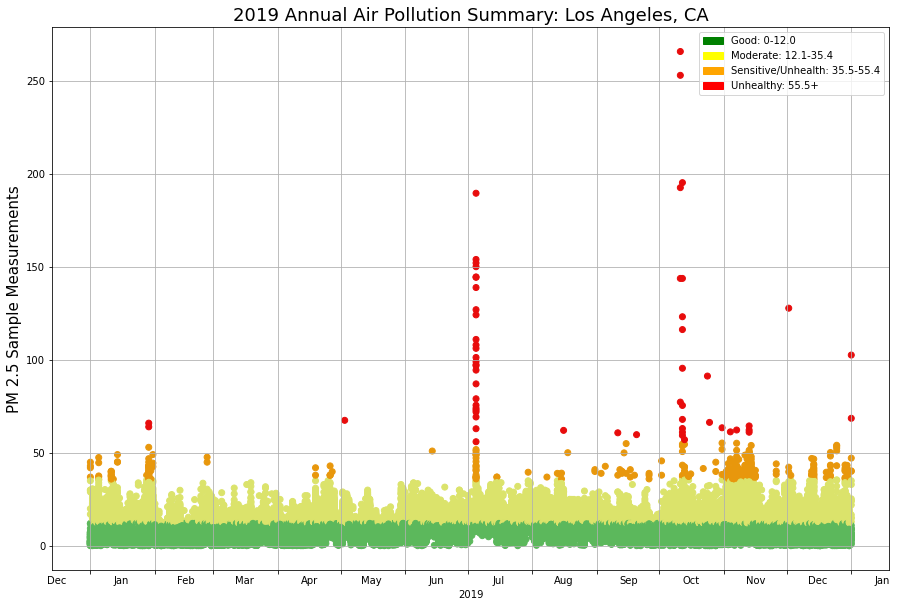

In [190]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.index.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values


# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

# Set month in xaxis by searching date format
ax.xaxis.set_major_locator(dates.MonthLocator())

# 16 is a slight approximation since months differ in number of days.
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# loop for custom tickers. Assign marker size and center text
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

imid = len(plot_df) // 2
ax.set_xlabel(str(date[imid].year))
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('2019 Annual Air Pollution Summary: Los Angeles, CA', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/LA_Annual_pm25_scatter.png")
plt.show()

### **Begin IQR research - Annual Sample Results**

In [191]:
# Copy of clean data
ca_la_box_data = ca_filtered_noIndexChange
# Sort Values
ca_la_box_data=ca_la_box_data.sort_values(["date_gmt", "time_gmt"])

In [192]:
# Set index to site_number. Sort values by site_number and time_gmt
ca_la_box_data.sort_values(by=['site_number','time_gmt'], ascending=True)

,county,site_number,sample_measurement,latitude,longitude,time_local,date_gmt,time_gmt,date_of_last_change
16,Los Angeles,16,4.7,34.144350,-117.850360,16:00,2019-01-02,00:00,2019-06-24
40,Los Angeles,16,7.3,34.144350,-117.850360,16:00,2019-01-03,00:00,2019-06-24
64,Los Angeles,16,7.0,34.144350,-117.850360,16:00,2019-01-04,00:00,2019-06-24
88,Los Angeles,16,15.2,34.144350,-117.850360,16:00,2019-01-05,00:00,2019-06-24
112,Los Angeles,16,11.4,34.144350,-117.850360,16:00,2019-01-06,00:00,2019-06-24
...,...,...,...,...,...,...,...,...,...
26336,Los Angeles,9034,5.9,34.813034,-118.884819,00:00,2019-06-14,08:00,2020-04-15
26337,Los Angeles,9034,4.7,34.813034,-118.884819,00:00,2019-06-17,08:00,2020-04-15
26338,Los Angeles,9034,5.9,34.813034,-118.884819,00:00,2019-06-20,08:00,2020-04-15
26339,Los Angeles,9034,3.1,34.813034,-118.884819,00:00,2019-06-23,08:00,2020-04-15


In [193]:
# Filter DF to only columns used
filtered_ca_la_box_data = ca_la_box_data[['sample_measurement', 'site_number','time_gmt']].set_index('site_number').sort_values(by=['site_number','time_gmt'], ascending=True)

In [194]:
# Make a list of site_numbers. Used in for loops to grab specific data by site number & used for new df header.
filtered_ca_la_box_list = filtered_ca_la_box_data.index.unique().tolist()

In [195]:
# Look through sample measurement list and count the amount of mice in each drug regimen.
# Create an empty list to fill with for loop
measurement_quartile=[]

# Search through filtered_ca_la_box_data with '.loc[site_number, 'sample_measurement' column]' and get the quartile
for i in filtered_ca_la_box_list:
    location = filtered_ca_la_box_data.loc[i, 'sample_measurement'].quantile(q=[.25, .5, .75])
    # append results to measurement_quartile list before moving to next value in tumor_regimen_list
    measurement_quartile.append(location)

In [196]:
measurement_quartile

[0.25     6.9
 0.50    10.7
 0.75    15.6
 Name: sample_measurement, dtype: float64,
 0.25     8.0
 0.50    12.0
 0.75    17.0
 Name: sample_measurement, dtype: float64,
 0.25     7.0
 0.50    10.9
 0.75    15.0
 Name: sample_measurement, dtype: float64,
 0.25     6.0
 0.50     9.4
 0.75    13.3
 Name: sample_measurement, dtype: float64,
 0.25     3.5
 0.50     6.7
 0.75    10.6
 Name: sample_measurement, dtype: float64,
 0.25    1.3
 0.50    2.2
 0.75    3.2
 Name: sample_measurement, dtype: float64]

In [197]:
iqr_all = []

# loop through measurement_quartile range (0-10). Find IQR by selecting one value at a time in the measurement_quartile list. 
for i in range(len(measurement_quartile)):
    iqr = (measurement_quartile[i][0.75])-(measurement_quartile[i][0.25])
    # Append finding to iqr_all list before moving to next value
    iqr_all.append(iqr)
#print(iqr_all)

In [198]:
# Show list. Verify we have correct amount
iqr_all

[8.7, 9.0, 8.0, 7.300000000000001, 7.1, 1.9000000000000001]

In [199]:
assert len(iqr_all) == 6

In [200]:
headers_list=['Glendora, CA (16)','Downtown LA (1103)','Reseda, CA (1201)','Long Beach, CA (4004)','Santa Clarita, CA (6012)','Lebec, CA (9034)']

In [201]:
# Round value.
round_iqr_all = [round(num, 2) for num in iqr_all]

# Combine both for loop generated list into one.
measurements_iqr_all = [dict(zip(headers_list, round_iqr_all))]
measurements_iqr_all

[{'Glendora, CA (16)': 8.7,
  'Downtown LA (1103)': 9.0,
  'Reseda, CA (1201)': 8.0,
  'Long Beach, CA (4004)': 7.3,
  'Santa Clarita, CA (6012)': 7.1,
  'Lebec, CA (9034)': 1.9}]

In [202]:
# Display in dataframe
measurements_iqr_all_df=pd.DataFrame(measurements_iqr_all)
measurements_iqr_all_df

,"Glendora, CA (16)",Downtown LA (1103),"Reseda, CA (1201)","Long Beach, CA (4004)","Santa Clarita, CA (6012)","Lebec, CA (9034)"
0,8.7,9.0,8.0,7.3,7.1,1.9


### Begin Box Plots - Annual Sample Results

In [203]:
# Values for plotting
box_plot_values = round_iqr_all
# Sort to determine outliers
values_sorted = sorted(box_plot_values)
print(values_sorted)

[1.9, 7.1, 7.3, 8.0, 8.7, 9.0]


In [204]:
# Reset dataframe for filtering
filtered_ca_la_box_data=filtered_ca_la_box_data.reset_index()

In [205]:
#Filter: By site location number. Set as own dataframe
ca_la_box_16=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 16]
ca_la_box_1103=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 1103]
ca_la_box_1201=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 1201]
ca_la_box_4004=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 4004]
ca_la_box_6012=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 6012]
ca_la_box_9034=filtered_ca_la_box_data[filtered_ca_la_box_data['site_number'] == 9034]

In [206]:
# Sample measurement values per site location
site_16_measurements = ca_la_box_16['sample_measurement']
site_1103_measurements = ca_la_box_1103['sample_measurement']
site_1201_measurements = ca_la_box_1201['sample_measurement']
site_4004_measurements = ca_la_box_4004['sample_measurement']
site_6012_measurements = ca_la_box_6012['sample_measurement']
site_9034_measurements = ca_la_box_9034['sample_measurement']
total = len(site_16_measurements)+len(site_1103_measurements)+len(site_1201_measurements)+len(site_4004_measurements)+len(site_6012_measurements)+len(site_9034_measurements)

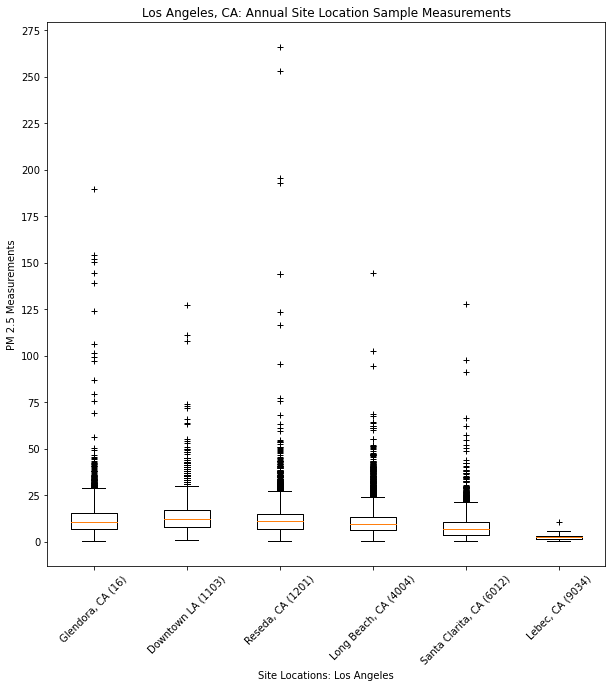

Total Samples Measured: 41824


<Figure size 432x288 with 0 Axes>

In [207]:
# Generate a box plot of the sample measurement of each site location, annually
measurement_plot_info = [site_16_measurements,site_1103_measurements,site_1201_measurements,site_4004_measurements,site_6012_measurements,site_9034_measurements]
plot_labels = ['Site 16','Site 1103','Site 1201','Site 4004','Site 6012','Site 9034']
fig, ax = plt.subplots(figsize=(10, 10))
pos = np.array(range(len(measurement_plot_info))) + 1
bp = ax.boxplot(measurement_plot_info, sym='k+', showfliers=True)

ax.set_xticklabels(headers_list, rotation=45)
ax.set_yticks(range(0, 300, 25))
ax.set_xlabel('Site Locations: Los Angeles')
ax.set_ylabel('PM 2.5 Measurements')
ax.set_title('Los Angeles, CA: Annual Site Location Sample Measurements')
plt.show()
plt.savefig("./Images/LA_Annual_pm25_boxplot.png")
print(f'Total Samples Measured: {total}')

Potential Outliers

Filtering by outlier values and dates may tell us which day/month of the year has larger than normal air pollution measurements. 

In [208]:
# Glendora, CA (16) Outliers
glendora_annual_outliers = bp["fliers"][0].get_data()[1]
glendora_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_16_measurements)}')
print(f'Total amount of outliers: {len(glendora_annual_outliers)}')
print(f'Glendora Outlier values: {glendora_annual_outliers}')

Total amount samples in set: 8575
Total amount of outliers: 131
Glendora Outlier values: [ 28.7  28.7  28.7  28.7  28.9  28.9  28.9  28.9  28.9  28.9  29.1  29.1
  29.1  29.1  29.1  29.1  29.1  29.2  29.4  29.4  29.4  29.4  29.4  29.4
  29.5  29.5  29.6  29.6  29.7  29.7  29.8  29.9  29.9  29.9  30.2  30.2
  30.4  30.4  30.4  30.4  30.6  30.6  30.6  30.6  30.8  30.9  31.1  31.1
  31.1  31.3  31.3  31.4  31.4  31.5  31.6  31.6  31.8  31.8  31.8  32.
  32.3  32.4  32.5  33.1  33.3  33.3  33.3  33.3  33.3  33.4  33.6  33.6
  33.8  33.8  34.   34.   34.3  34.5  34.5  34.7  35.   35.   35.5  35.5
  35.7  35.7  36.   36.1  37.   37.2  38.   38.   38.2  38.2  38.2  38.7
  39.   39.3  40.   40.4  40.4  40.4  41.4  41.6  41.6  42.1  42.4  42.6
  43.4  44.5  45.   45.3  46.7  49.1  50.3  56.   69.3  75.6  79.1  87.1
  96.9  99.1 101.3 106.2 124.2 138.9 144.6 150.1 152.1 154.  189.6]


In [209]:
# Downtown LA, CA (1103) Outliers
la_annual_outliers = bp["fliers"][1].get_data()[1]
la_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_1103_measurements)}')
print(f'Total amount of outliers: {len(la_annual_outliers)}')
print(f'Downtown LA Outlier values: {la_annual_outliers}')

Total amount samples in set: 8499
Total amount of outliers: 214
Downtown LA Outlier values: [ 31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.
  31.  31.  31.  31.  31.  31.  31.  31.  31.  31.  32.  32.  32.  32.
  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.
  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  32.  33.
  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.
  33.  33.  33.  33.  33.  33.  33.  33.  33.  33.  34.  34.  34.  34.
  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  34.  35.  35.
  35.  35.  35.  35.  35.  35.  35.  35.  35.  36.  36.  36.  36.  36.
  36.  36.  36.  36.  37.  37.  37.  37.  37.  37.  37.  37.  37.  37.
  37.  37.  37.  37.  37.  37.  38.  38.  38.  38.  38.  38.  38.  38.
  38.  38.  38.  38.  38.  38.  38.  38.  38.  39.  39.  39.  39.  39.
  39.  39.  39.  39.  39.  39.  39.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  40.  41.  41.  41.  41.  41.  42.  42.  42. 

In [210]:
# Reseda, CA (1201) Outliers
reseda_annual_outliers = bp["fliers"][2].get_data()[1]
reseda_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_1201_measurements)}')
print(f'Total amount of outliers: {len(reseda_annual_outliers)}')
print(f'Reseda Outlier values: {reseda_annual_outliers}')

Total amount samples in set: 8584
Total amount of outliers: 257
Reseda Outlier values: [ 27.1  27.1  27.1  27.1  27.2  27.2  27.2  27.2  27.3  27.3  27.4  27.5
  27.5  27.5  27.5  27.5  27.5  27.5  27.5  27.6  27.6  27.6  27.6  27.6
  27.6  27.8  27.8  27.8  27.8  27.9  28.   28.   28.   28.   28.   28.1
  28.1  28.1  28.1  28.1  28.1  28.1  28.1  28.3  28.3  28.3  28.4  28.4
  28.4  28.5  28.5  28.6  28.6  28.7  28.8  28.8  28.8  28.8  28.8  28.8
  28.8  28.9  29.   29.   29.   29.   29.2  29.2  29.2  29.2  29.3  29.3
  29.3  29.3  29.3  29.3  29.3  29.3  29.3  29.4  29.5  29.5  29.5  29.6
  29.6  29.6  29.7  29.7  29.8  29.8  29.9  30.   30.   30.   30.   30.
  30.1  30.1  30.3  30.3  30.3  30.3  30.4  30.5  30.5  30.5  30.5  30.5
  30.5  30.6  30.6  30.6  30.7  30.8  30.9  31.   31.   31.   31.   31.1
  31.2  31.2  31.3  31.3  31.3  31.4  31.5  31.5  31.6  31.6  31.7  31.9
  32.   32.1  32.2  32.2  32.2  32.2  32.3  32.4  32.4  32.4  32.5  32.7
  32.9  33.   33.1  33.1  33.3  33.4  

In [211]:
# Long Beach, CA (4004) Outliers
lb_annual_outliers = bp["fliers"][3].get_data()[1]
lb_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_4004_measurements)}')
print(f'Total amount of outliers: {len(lb_annual_outliers)}')
print(f'Long Beach Outlier values: {lb_annual_outliers}')

Total amount samples in set: 8611
Total amount of outliers: 416
Long Beach Outlier values: [ 24.3  24.3  24.3  24.3  24.3  24.3  24.3  24.4  24.4  24.4  24.4  24.4
  24.4  24.4  24.4  24.4  24.4  24.4  24.6  24.6  24.6  24.6  24.6  24.6
  24.6  24.6  24.6  24.6  24.6  24.6  24.6  24.6  24.7  24.7  24.7  24.7
  24.8  24.8  24.8  24.9  24.9  24.9  24.9  24.9  24.9  24.9  24.9  24.9
  24.9  25.1  25.1  25.1  25.1  25.1  25.1  25.1  25.1  25.1  25.2  25.2
  25.3  25.3  25.3  25.4  25.4  25.4  25.4  25.6  25.6  25.6  25.6  25.6
  25.6  25.6  25.6  25.6  25.7  25.8  25.8  25.9  25.9  25.9  25.9  25.9
  25.9  25.9  25.9  25.9  25.9  26.   26.1  26.1  26.1  26.1  26.1  26.2
  26.3  26.3  26.3  26.4  26.4  26.4  26.4  26.4  26.4  26.4  26.4  26.4
  26.4  26.5  26.6  26.6  26.6  26.6  26.6  26.6  26.6  26.6  26.6  26.6
  26.6  26.8  26.8  26.8  26.8  26.9  26.9  26.9  26.9  26.9  26.9  27.1
  27.1  27.1  27.1  27.3  27.3  27.3  27.4  27.4  27.4  27.4  27.4  27.4
  27.4  27.5  27.5  27.5  27.5  2

In [212]:
# Santa Clarita, CA (6012) Outliers
santaclarita_annual_outliers = bp["fliers"][4].get_data()[1]
santaclarita_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_6012_measurements)}')
print(f'Total amount of outliers: {len(santaclarita_annual_outliers)}')
print(f'Santa Clarita Outlier values: {santaclarita_annual_outliers}')

Total amount samples in set: 7506
Total amount of outliers: 212
Santa Clarita Outlier values: [ 21.3  21.4  21.4  21.4  21.4  21.4  21.4  21.4  21.4  21.4  21.6  21.6
  21.6  21.6  21.6  21.6  21.6  21.6  21.6  21.6  21.8  21.8  21.9  21.9
  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9  21.9
  22.   22.1  22.1  22.1  22.1  22.1  22.1  22.1  22.1  22.2  22.2  22.3
  22.3  22.3  22.4  22.4  22.4  22.4  22.4  22.4  22.4  22.4  22.6  22.6
  22.6  22.6  22.6  22.7  22.8  22.8  22.8  22.8  22.8  22.9  22.9  22.9
  23.   23.1  23.1  23.1  23.1  23.1  23.3  23.3  23.3  23.3  23.3  23.3
  23.4  23.4  23.6  23.6  23.6  23.8  23.8  23.8  23.8  23.8  23.8  23.8
  23.8  23.9  24.1  24.1  24.1  24.1  24.2  24.3  24.3  24.3  24.3  24.3
  24.3  24.3  24.3  24.3  24.3  24.4  24.4  24.5  24.5  24.5  24.5  24.5
  24.5  24.7  24.8  24.8  24.9  25.   25.   25.1  25.3  25.3  25.3  25.3
  25.5  25.5  25.5  25.5  25.8  26.   26.   26.1  26.2  26.3  26.5  26.5
  26.6  26.8  26.8  26.8  27. 

In [213]:
# Lebec, CA (9034) Outliers
Lebec_annual_outliers = bp["fliers"][5].get_data()[1]
Lebec_annual_outliers.sort(axis=-1, kind='quicksort', order=None)
print(f'Total amount samples in set: {len(site_9034_measurements)}')
print(f'Total amount of outliers: {len(Lebec_annual_outliers)}')
print(f'Lebec Outlier values: {Lebec_annual_outliers}')

Total amount samples in set: 49
Total amount of outliers: 1
Lebec Outlier values: [10.4]


## **Measurements by time of day**

Single Day

In [214]:
range_time = single_date_ca_air['time_gmt'].sort_values().unique()
range_time

array(['08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00'], dtype=object)

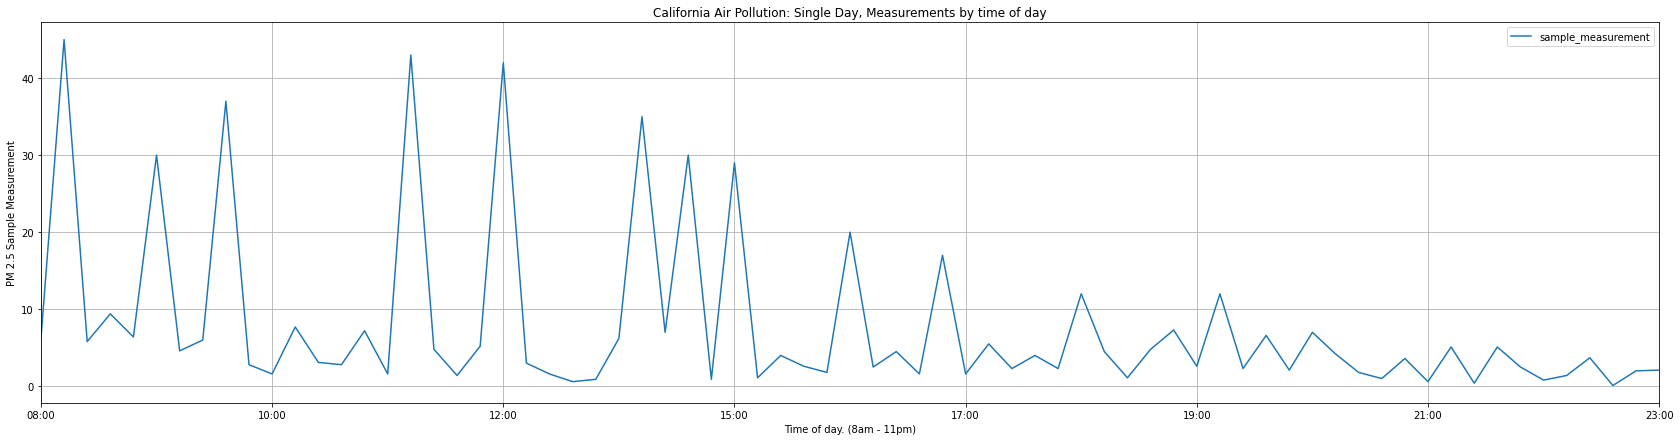

In [215]:
single_date_ca_air.sort_values(by='time_gmt', axis=0).plot(x='time_gmt', y='sample_measurement', kind='line', figsize=(29, 7),grid=True, title="California Air Pollution: Single Day, Measurements by time of day")
#plt.xticks(np.arange(int(test),int(test2), 3.5))
plt.ylabel('PM 2.5 Sample Measurement')
plt.xlabel('Time of day. (8am - 11pm)')
plt.xlim([0,70])
plt.show()

### Every day of the year by Time of day

In [216]:
# dataframe to plot
plot_df = california_clean_data.copy()
plot_df=plot_df.sort_values('time_gmt')
#ax.plot(date, site_number_1103.sample_measurement)
plot_y_information = plot_df.sample_measurement

In [217]:
color_threshold = plot_df.color

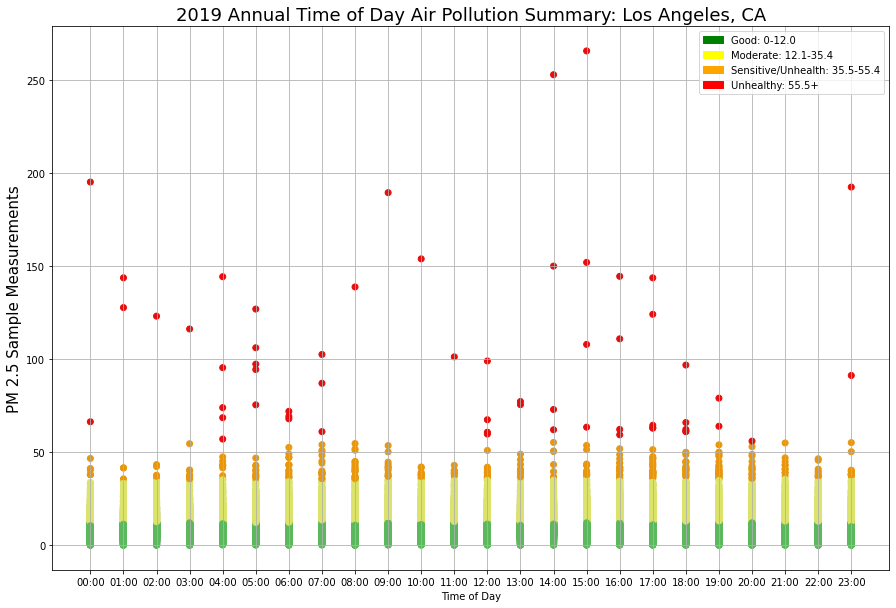

In [218]:
# Assigm date as index of dataframe. Dataframe index has dates
date = plot_df.time_gmt.astype('O')

# Data for plt
x = date
y = plot_y_information
c = color_threshold.values

# Plot subplots
fig, ax = plt.subplots(figsize=(15,10))
scatter = ax.scatter(x,y, c=c)

imid = len(plot_df) // 2
ax.set_xlabel('Time of Day')
ax.set_ylabel('PM 2.5 Sample Measurements', size=15)
ax.set_title('2019 Annual Time of Day Air Pollution Summary: Los Angeles, CA', size=18)
plt.grid(True)

# Labels for legend
green = mpatches.Patch(color='green', label='Good: 0-12.0')
yellow = mpatches.Patch(color='yellow', label='Moderate: 12.1-35.4')
orange = mpatches.Patch(color='orange', label='Sensitive/Unhealth: 35.5-55.4')
red = mpatches.Patch(color='red', label='Unhealthy: 55.5+')
#Call legend
plt.legend(handles = [green,yellow,orange,red])

# Save an image of the chart and print it to the screen
plt.savefig("./Images/LA_Annual_TimeofDay_pm25_scatter.png")
plt.show()